In [10]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
#suppressMessages(library(xts))
suppressMessages(library(forecast))

ERROR: Error in library(forecast): there is no package called ‘forecast’


# Marriages Prediction

### Background :

Marriage is a union between two people that allows them to be recognised as a couple in the eyes of the law. Marriages allows for tax benefits and adoption rights.  

Marriage is one of the largest expenditures in a couples life and is a large industry in Australia. Accoding to http://www.weddingindustry.com.au/ is approximately $2 billion per year. 

Today we will look at marriages in Queensland, Australia

The data set is the number of marriages recorded per month from 2010 to 2017. found on https://www.data.qld.gov.au/dataset/marriages-by-month/
(Initially we used data from 2010 to 2016 in order to forecast the 2017 numbers, with 2017 numbers later downloaded to see how we went)

We want to predict the number of monthly marriages that will happen in 2017. This is highly usefull for governments and businesses

 - Businesses who rely on casual hires to cover the peak seasons.
 - Marketing and production for products targeted at weddings/newly married couples


### Methods
1. Data
    - Data needs to be merged from seperate csv
    - Loaded into a time series object
2. Exploratory Analysis
3. Model Selection
    - Baseline
    - ETS
    - ARIMA
4. Evaluate

E

# 1) Merge Dataset

In [1]:
df2016 <- read.csv('Marriages2016.csv')
df2015 <- read.csv('Marriages2015.csv')
df2014 <- read.csv('Marriages2014.csv')
df2013 <- read.csv('Marriages2013.csv')
df2012 <- read.csv('Marriages2012.csv')
df2011 <- read.csv('Marriages2011.csv')
df2010 <- read.csv('Marriages2010.csv')

In [2]:
df2016 <- cbind(year=2016,df2016)
df2015 <- cbind(year=2015,df2015)
df2014 <- cbind(year=2014,df2014)
df2013 <- cbind(year=2013,df2013)
df2012 <- cbind(year=2012,df2012)
df2012<- df2012[1:12,]
df2011 <- cbind(year=2011,df2011)
df2010 <- cbind(year=2010,df2010)

In [3]:
df <- do.call("rbind", list(df2010,df2011,df2012, df2013, df2014,df2015,df2016))

In [4]:
df1 <- df

In [5]:
df1$date <- paste(df1$year,df1$Month,'01',sep='-')

In [6]:
df2 <- subset(df1, select = c('date','Transactions'))

In [8]:
year_totals <- colSums(matrix(df$Transactions, nrow=12))

In [13]:
year_totals

[1] 26824 25638 26277 25103 25076 23637 22900

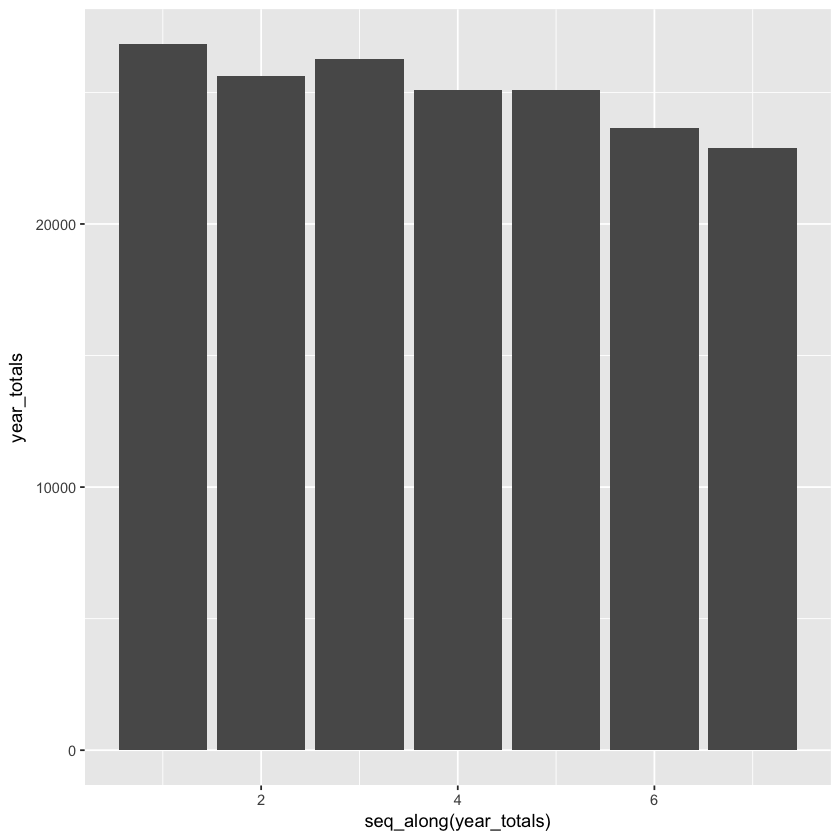

In [16]:
ggplot(data.frame(year_totals),aes(seq_along(year_totals),year_totals))+geom_bar(stat="identity")

In [6]:
final_test <- read.csv('Marriages2017.csv')

In [7]:
mts <- ts(df$Transactions, start = c(2010, 1), frequency=12)

In [8]:
test_mts <- ts(final_test$Transactions, start = c(2017, 1), frequency=12)

In [9]:
sum(test_mts)

[1] 22347

# 2) Exploring and Analysing the data

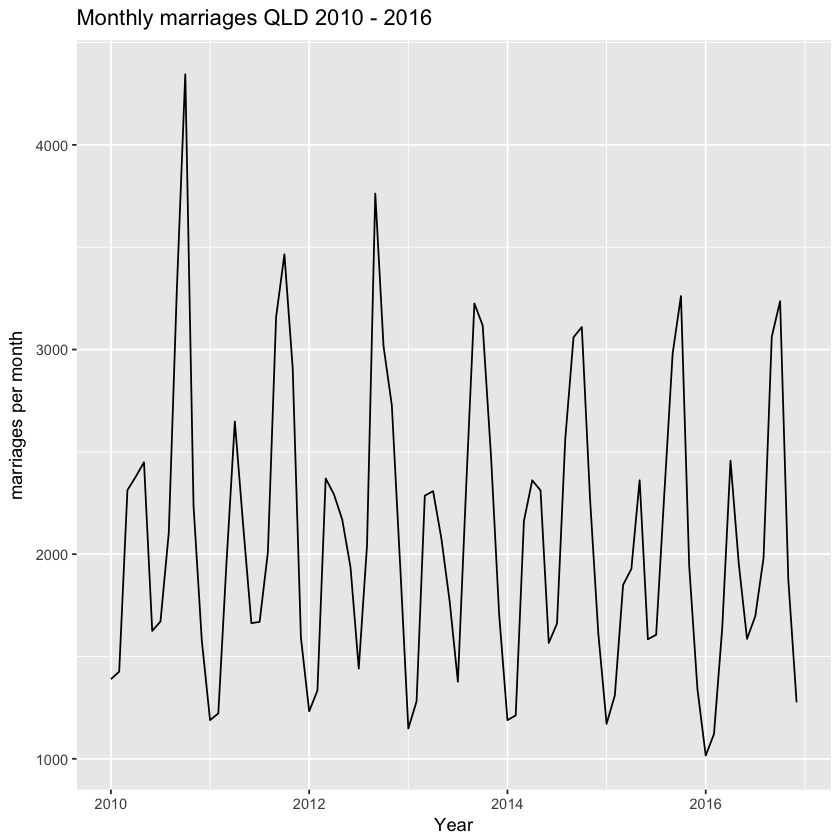

In [10]:
autoplot(mts) +
  ggtitle("Monthly marriages QLD 2010 - 2016") +
  ylab("marriages per month") + xlab("Year")

We can see that our time series has seasonality and a slight downward trend. Big spike in 2010 and getting smaller.

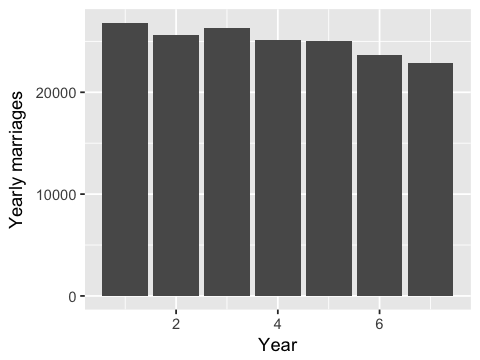

In [23]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(data.frame(year_totals),aes(seq_along(year_totals),year_totals))+geom_bar(stat="identity")+
    ylab("Yearly marriages") + xlab("Year ")

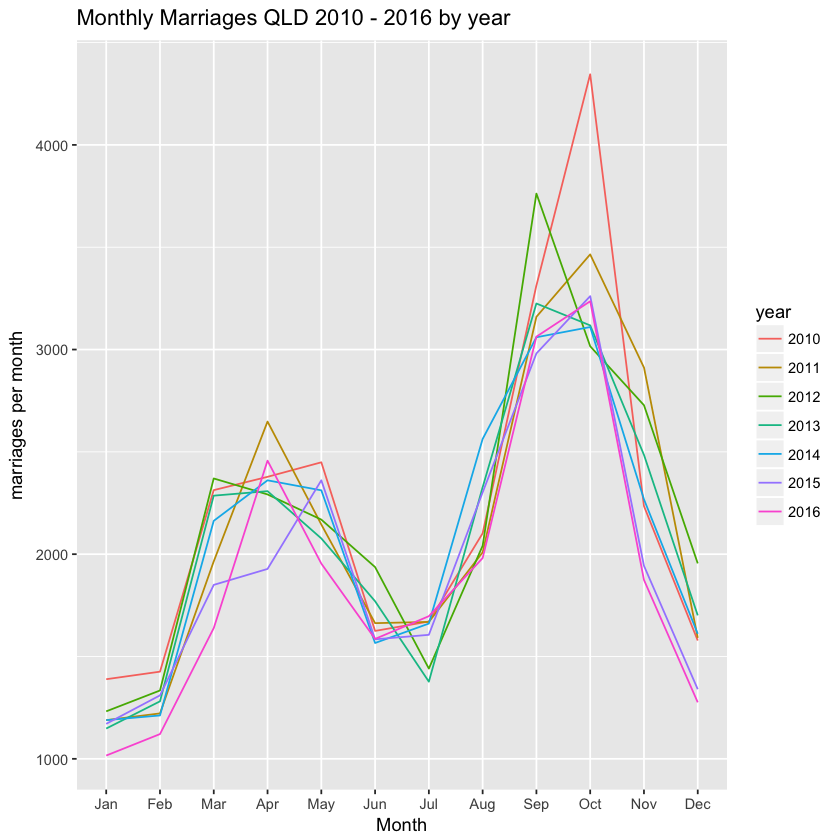

In [11]:
ggseasonplot(mts) + ggtitle("Monthly Marriages QLD 2010 - 2016 by year") + ylab("marriages per month")

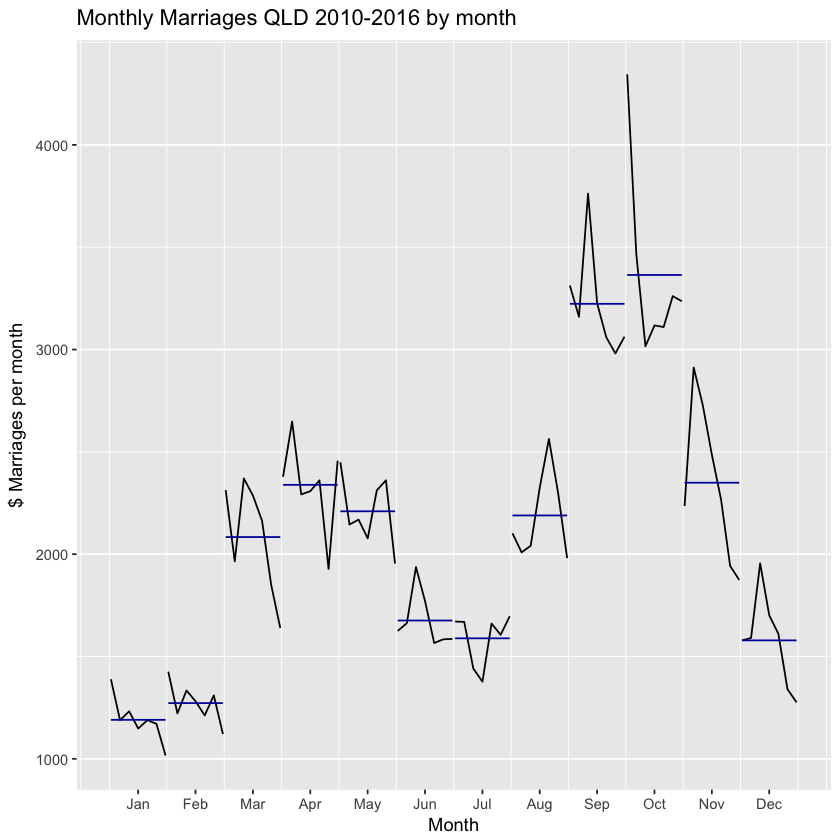

In [12]:
ggsubseriesplot(mts) + ylab("$ Marriages per month") +
  ggtitle("Monthly Marriages QLD 2010-2016 by month")

September, October are the most popular months. April marriages are on the rise.

### Time series decomposition 

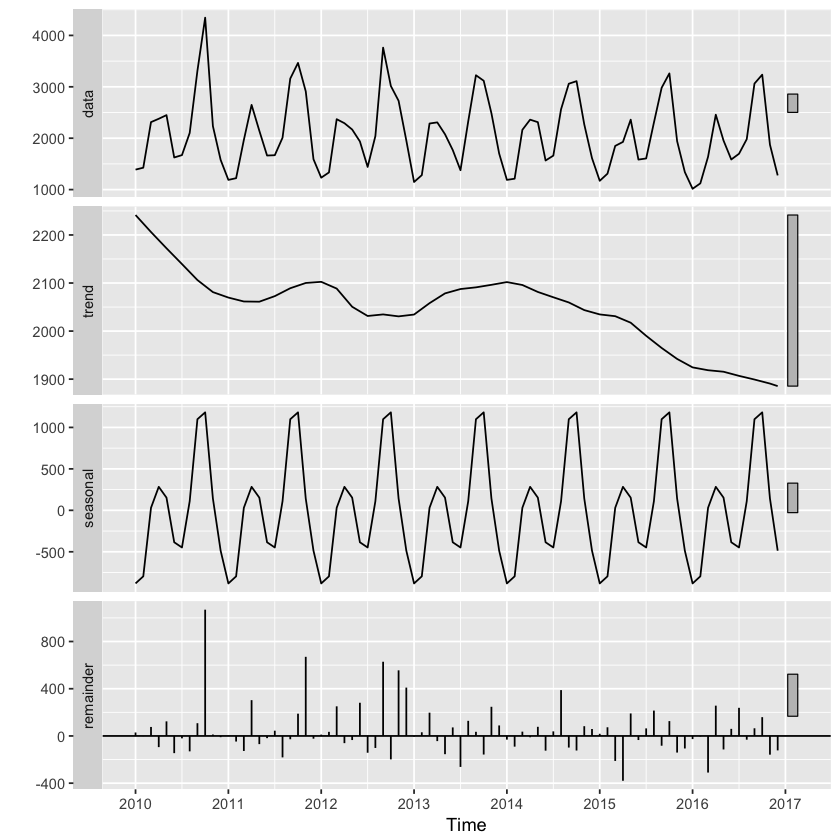

In [13]:
autoplot(stl(mts, s.window="periodic", robust=TRUE))

# 3) Model Selection

In [14]:
train <- window(mts, 2010, c(2015, 12))
test <- window(mts, 2016, c(2016, 12))

Lets fit a baseline model.

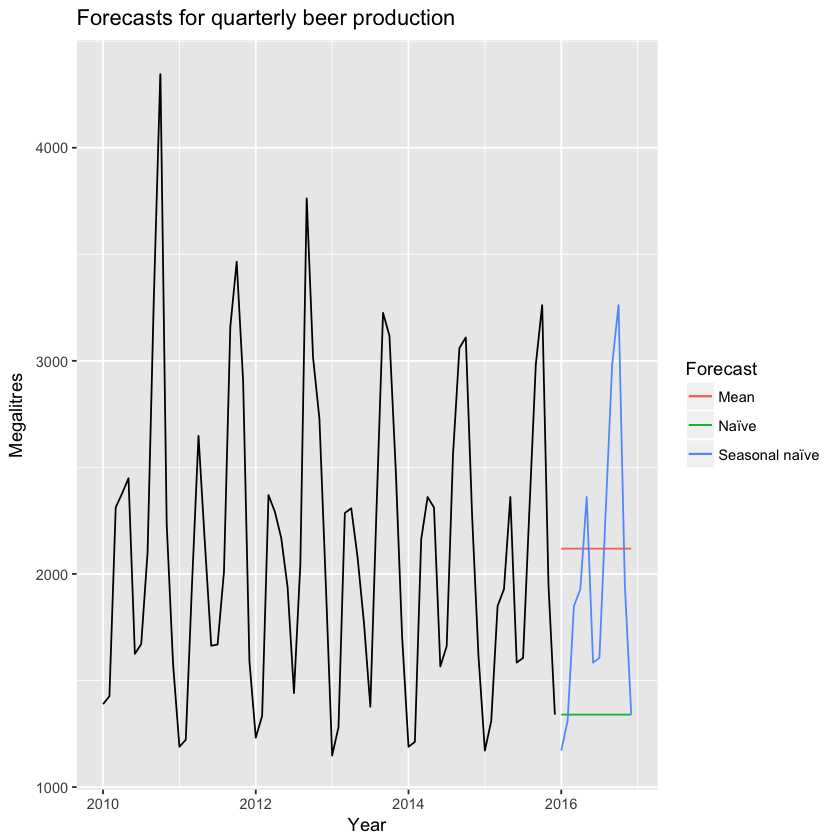

In [15]:
autoplot(train) +
  forecast::autolayer(meanf(train, h=12)$mean, series="Mean") +
  forecast::autolayer(naive(train, h=12)$mean, series="Naïve") +
  forecast::autolayer(snaive(train, h=12)$mean, series="Seasonal naïve") +
  ggtitle("Forecasts for quarterly beer production") +
  xlab("Year") + ylab("Megalitres") +
  guides(colour=guide_legend(title="Forecast"))

In [16]:
fit.sn <- snaive(train,h=12)

In [17]:
accuracy(forecast(fit.sn,h=12)$mean, test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-61.41667,237.5726,178.75,-5.149735,10.09906,-0.5465098,0.4579452


RMSE of 237.57 will be the base line error that we will try to improve upon.

In [18]:
res <- residuals(fit.sn)

In [19]:
Box.test(res, lag=12, fitdf=4, type="Ljung")


	Box-Ljung test

data:  res
X-squared = 18.063, df = 8, p-value = 0.02076


In [20]:
e <- tsCV(mts, rwf, drift=TRUE, h=1)

In [21]:
sqrt(mean(e^2, na.rm=TRUE))

[1] 705.8944

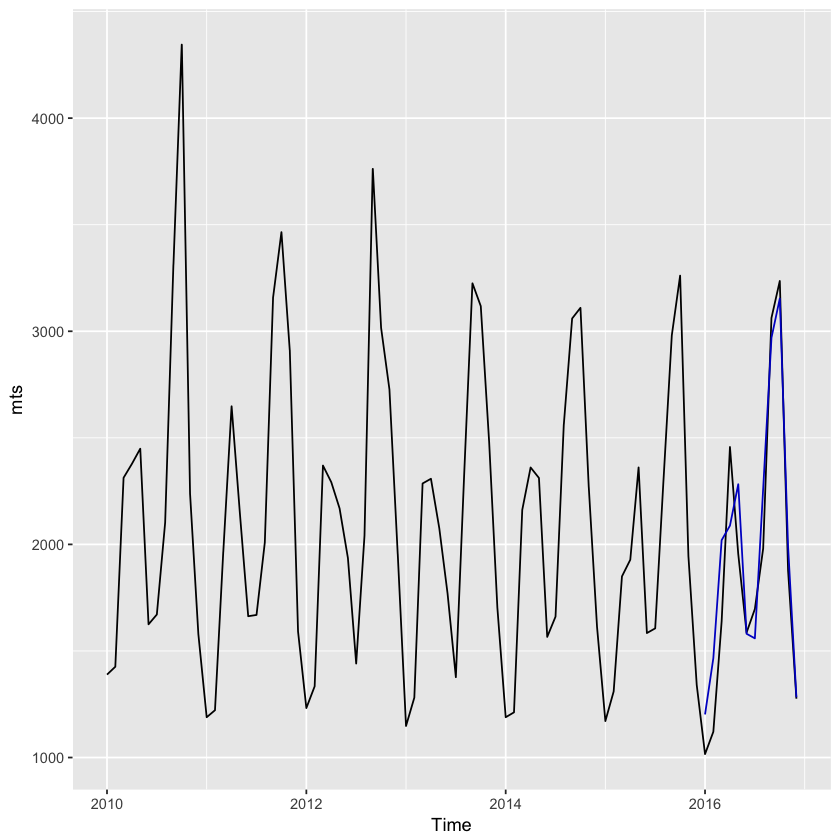

In [22]:
fit.nn <- nnetar(train, lambda=0)
autoplot(mts) + forecast::autolayer(forecast(fit.nn,h=12))

# ETS

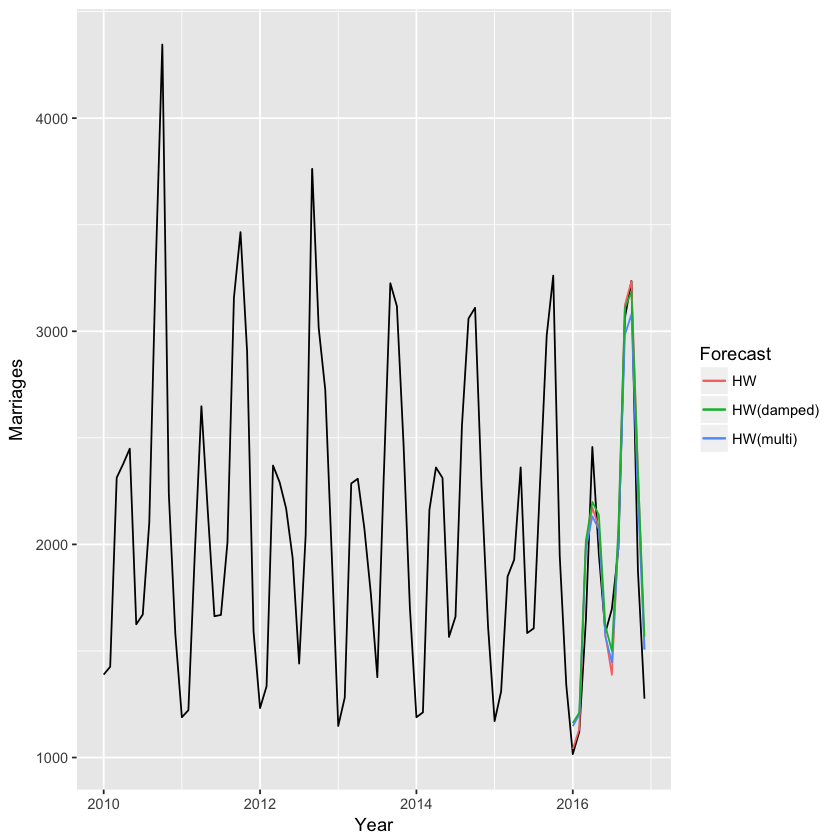

In [23]:
fit.ets1 <- hw(train,seasonal="additive",h=12)
fit.ets2 <- hw(train,seasonal="multiplicative",h=12)
fit.ets3 <- hw(train,damped=TRUE,seasonal="multiplicative",h=12)
autoplot(mts) +
  forecast::autolayer(fit.ets1$mean, series="HW") +
  forecast::autolayer(fit.ets2$mean, series="HW(multi)") +
  forecast::autolayer(fit.ets3$mean, series="HW(damped)") +
  xlab("Year") + ylab("Marriages") +
  guides(colour=guide_legend(title="Forecast"))

In [24]:
fit.sn <- snaive(train,h=12)
fit.aa <- auto.arima(train)

In [25]:
accuracy(forecast(fit.nn,h=12)$mean, test)
accuracy(forecast(fit.ets1,h=12)$mean, test)
accuracy(forecast(fit.ets2,h=12)$mean, test)
accuracy(forecast(fit.ets3,h=12)$mean, test)
accuracy(forecast(fit.sn,h=12)$mean, test)
accuracy(forecast(fit.aa, h=12)$mean, test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-79.36425,236.0495,193.9856,-6.731616,11.57544,-0.3355072,0.5392484


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-61.05745,223.8809,161.6909,-4.105219,9.170039,-0.1170756,0.4201511


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-36.91145,208.3663,175.2195,-4.00506,10.10206,-0.1727883,0.4088003


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-101.9767,228.6859,186.162,-7.268896,11.20716,-0.1850818,0.4300565


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-61.41667,237.5726,178.75,-5.149735,10.09906,-0.5465098,0.4579452


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-19.70067,235.3983,174.6467,-3.019327,9.730234,-0.5024742,0.4386047


In [26]:
Combination <- (
                forecast(fit.aa,h=12)$mean + 
                forecast(fit.ets2,h=12)$mean + 
                forecast(fit.ets1,h=12)$mean 
                )/3

In [27]:
accuracy(Combination, test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-39.22319,199.1898,167.1658,-3.709869,9.557967,-0.376632,0.3895601


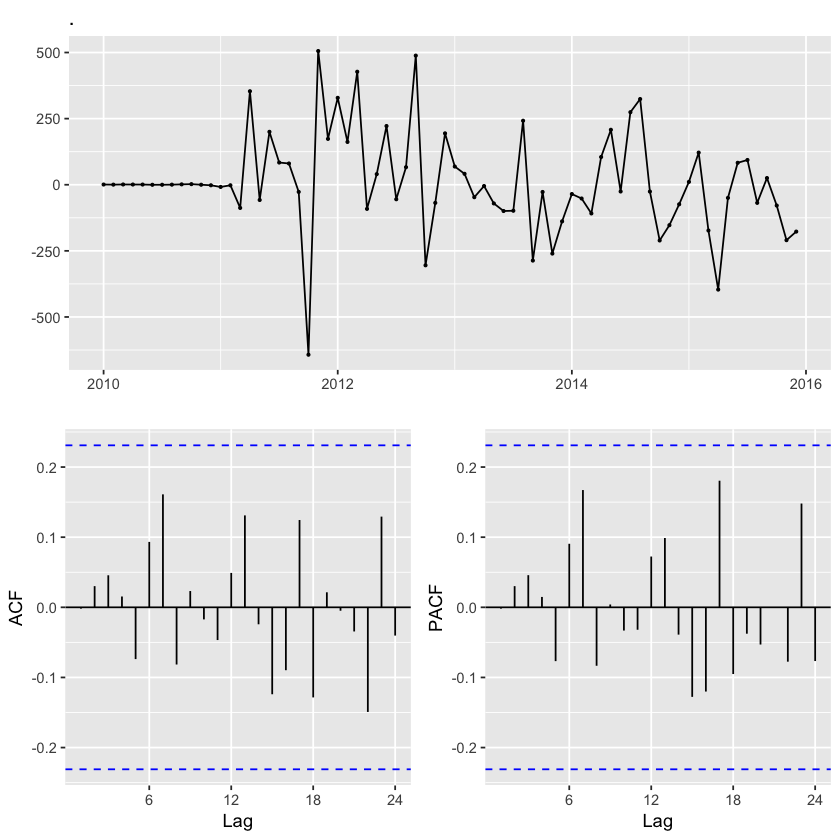

In [28]:
train %>%
  Arima(order=c(2,1,2), seasonal=c(3,1,1)) %>%
  residuals %>%
  ggtsdisplay

In [29]:
fit.arima1 <- Arima(train,order=c(2,1,3), seasonal=c(3,1,1))

In [30]:
fcast.arima <- forecast(fit.arima1, h=12)$mean
fcast.ets <- forecast(fit.ets2,h=12)$mean

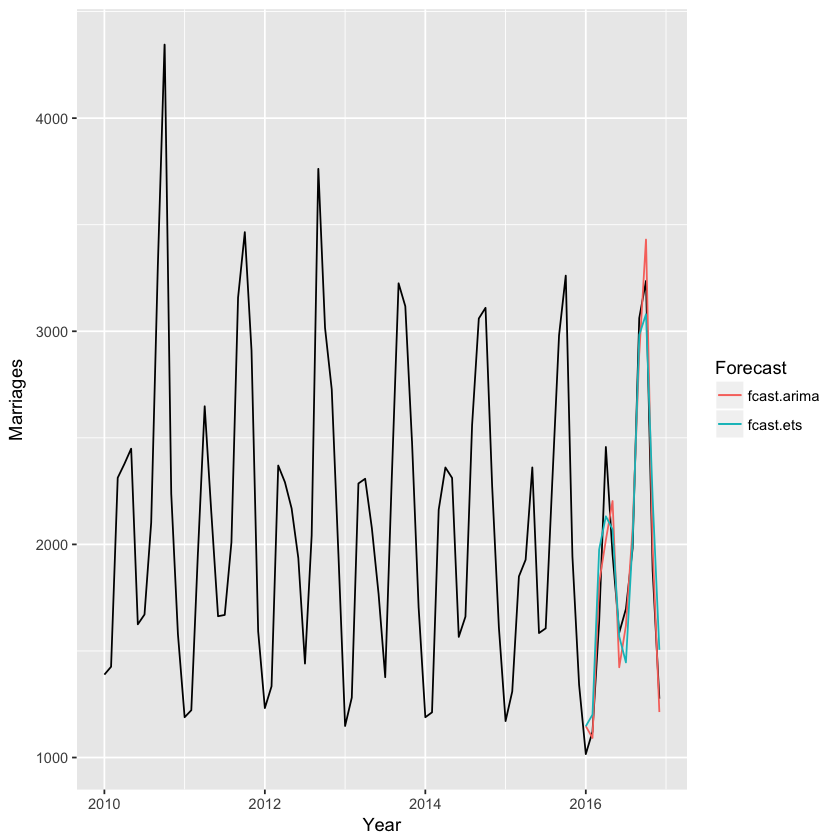

In [31]:
autoplot(mts) +
  forecast::autolayer(fcast.arima) +
  forecast::autolayer(fcast.ets) +
  xlab("Year") + ylab("Marriages") +
  guides(colour=guide_legend(title="Forecast"))

In [32]:
accuracy(fcast.arima, test)
accuracy(fcast.ets, test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-1.697471,188.4264,157.6635,-0.632198,8.22714,-0.6236964,0.3392899


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-36.91145,208.3663,175.2195,-4.00506,10.10206,-0.1727883,0.4088003


# Real data validation

our best performing model was ARIMA. Now that we have the lets test few of the best models and see which perfomed well on an actual data.

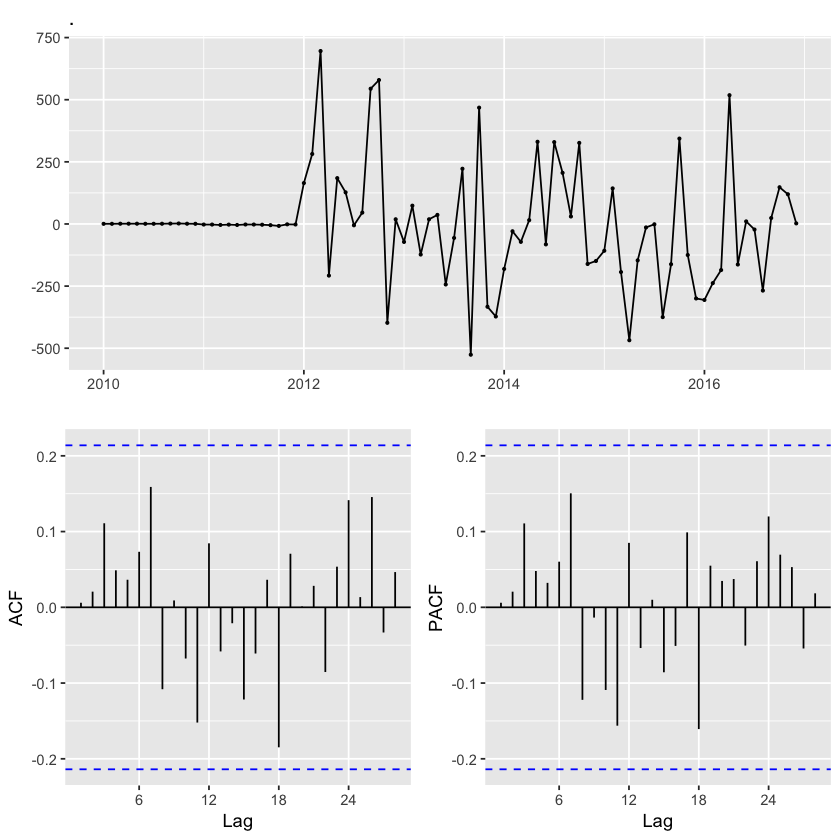

In [33]:
mts %>%
  Arima(order=c(2,0,1), seasonal=c(0,2,1)) %>%
  residuals %>%
  ggtsdisplay

In [34]:
fit.arima <- Arima(mts,order=c(2,0,1), seasonal=c(0,2,1))
fcast.arima <- forecast(fit.arima, h=12)$mean

In [35]:
accuracy(fcast.arima, test_mts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,7.333803,169.5981,117.7322,0.60398,5.465141,-0.4602135,0.2385778


In [36]:
fit.ets2 <- hw(mts,seasonal="multiplicative",h=12)
fcast.ets <- forecast(fit.ets2,h=12)$mean
accuracy(fcast.ets, test_mts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-3.616482,261.6685,204.4421,-2.012729,10.48331,-0.01131626,0.4259573


In [37]:
fit.sn <- snaive(mts,h=12)
fcast.sn <- forecast(fit.sn,h=12)$mean
accuracy(fcast.sn, test_mts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-46.08333,201.6207,125.5833,-2.495625,5.844172,-0.3154462,0.2335737


In [38]:
fit.aa

Series: train 
ARIMA(0,0,1)(0,1,0)[12] with drift 

Coefficients:
          ma1    drift
      -0.3421  -4.1779
s.e.   0.1154   1.7706

sigma^2 estimated as 63364:  log likelihood=-415.88
AIC=837.76   AICc=838.19   BIC=844.04

In [39]:
fit.aa <- auto.arima(mts)
fit.nn <- nnetar(mts, lambda=0)
fit.ets1 <- hw(mts,seasonal="additive",h=12)
fit.ets3 <- hw(mts,damped=TRUE,seasonal="multiplicative",h=12)

In [40]:
fcast.aa <- forecast(fit.aa,h=12)$mean
fcast.nn <- forecast(fit.nn,h=12)$mean
fcast.ets1 <- forecast(fit.ets1,h=12)$mean
fcast.ets3 <- forecast(fit.ets3,h=12)$mean

In [41]:
accuracy(fcast.aa, test_mts)
accuracy(fcast.nn, test_mts)
accuracy(fcast.ets1, test_mts)
accuracy(fcast.ets3, test_mts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-3.420955,199.7954,122.4858,-0.3856458,5.394174,-0.3648737,0.2563777


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-49.23035,196.6262,142.6704,-3.255642,7.085795,-0.202284,0.2622017


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-22.20203,274.4878,207.9876,-1.729722,10.54787,0.04645478,0.422177


,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-63.76763,265.9087,223.0454,-5.430441,12.09636,0.0251659,0.426513


In [42]:
combo1 <- (fcast.nn + fcast.arima  + fcast.sn)/3

In [43]:
accuracy(combo1, test_mts)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-29.32663,181.7444,115.4706,-1.715762,5.438976,-0.308336,0.2202944


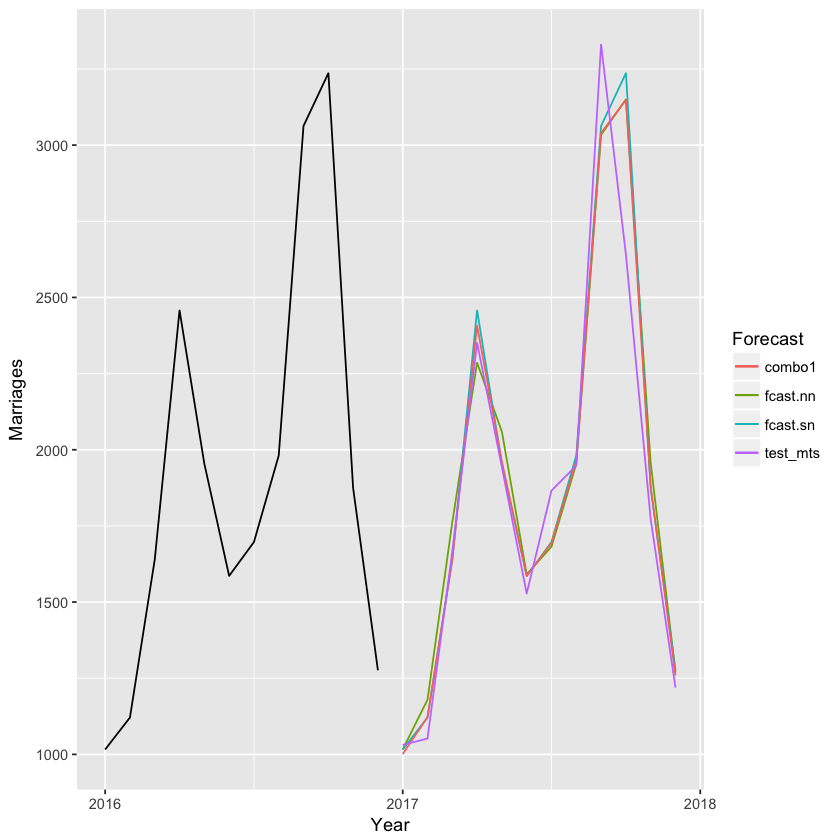

In [44]:
autoplot(test) +
  forecast::autolayer(fcast.nn) +
  forecast::autolayer(fcast.sn) +
  forecast::autolayer(combo1) +
  forecast::autolayer(test_mts) +
  xlab("Year") + ylab("Marriages") +
  guides(colour=guide_legend(title="Forecast"))

# Conclusion

The best we could do is +/- 190 or 183 using the ensemble. 

In [45]:
fcast.nn - test_mts

             Jan         Feb         Mar         Apr         May         Jun
2017  -14.765493  127.541180   96.923929  -65.420557  116.172314   63.238097
             Jul         Aug         Sep         Oct         Nov         Dec
2017 -184.123647    5.548292 -296.330291  508.035326  184.349179   49.595906

We can see that we over forecasted September by 272 and underforcasted Oct by 533

These do predicted badly in the peak season but if we actually examine the season as a whole we only missed by 260 marriages for the two months.

People plan their marriages. If not in september they will tie the knot in october. 

It will be interesting to see if the passing of same-sex marriage will have any effect. It could be argued that we should expect lots of new marriages in 2018 dues to backlog of people waiting to get married and then a steady rate of same-sex marriages. 

This will p

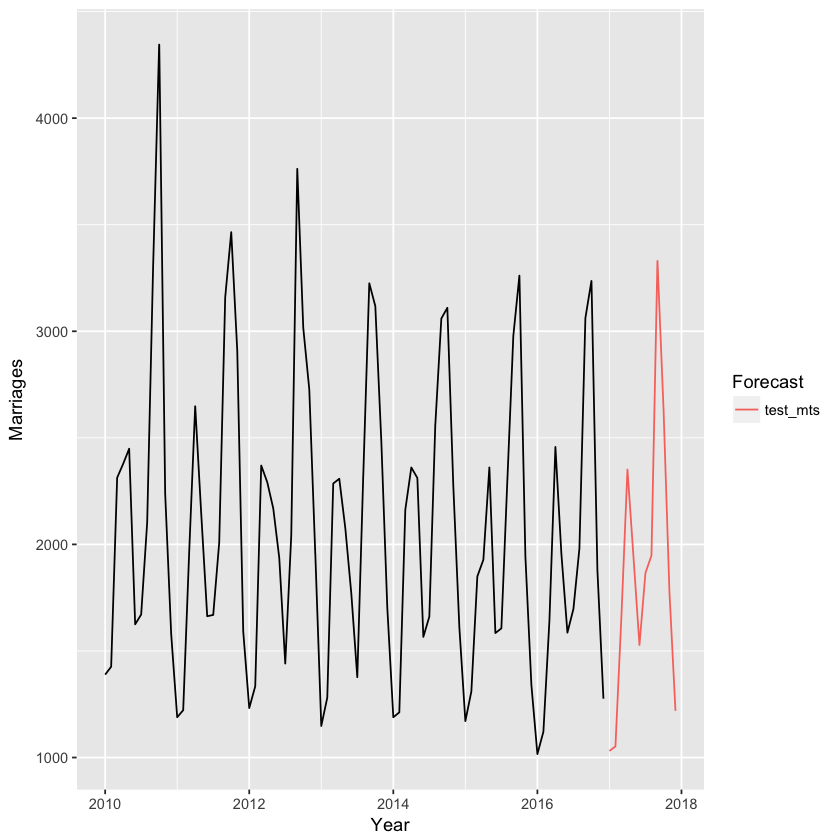

In [46]:
autoplot(mts) +
  forecast::autolayer(test_mts) +
  xlab("Year") + ylab("Marriages") +
  guides(colour=guide_legend(title="Forecast"))